In [100]:
# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# from sklearn.feature_selection import SelectKBest, f_regression
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as tts

from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn import metrics  # For evaluation metrics
import xgboost as xgb #pip install xgboost
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score, learning_curve, validation_curve

from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from hyperopt.pyll.base import scope



In [101]:
# Load Data
columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area',
           'Central Air', 'Total Bsmt SF', 'SalePrice', 'Lot Area', 
           'Full Bath', 'Half Bath', 'TotRms AbvGrd', 'Fireplaces', 'Wood Deck SF']

df = pd.read_csv('AmesHousing.txt',
                 sep='\t',
                 usecols=columns)

In [102]:
#Pipeline for data cleaning -> train_test_split -> and Model Training
df["Central_Air_Binary"] = df['Central Air'].map({'N': 0, 'Y': 1})
y = df["SalePrice"]
X = df.drop(["Central Air", "SalePrice"], axis = 1)

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)

pipelines = {
    'xgb': Pipeline([('scaler', MinMaxScaler()), ('xgb', xgb.XGBRegressor())]),
    'rf': Pipeline([('scaler', MinMaxScaler()), ('rf', RandomForestRegressor())])
}


pipelines['xgb'].fit(X_train, y_train)
pipelines['rf'].fit(X_train, y_train)



Pipeline(steps=[('scaler', MinMaxScaler()), ('rf', RandomForestRegressor())])

In [103]:
# R2, MAE, MSE 
y_pred = pipelines['xgb'].predict(X_test)
mse = metrics.mean_squared_error(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
print(f"Model: XGB Regression")
print(f"  MSE: {mse:.2f}")
print(f"  MAE: {mae:.2f}")
print(f"  R-squared: {r2:.2f}")
print("-----------------")



Model: XGB Regression
  MSE: 1025029869.01
  MAE: 19705.04
  R-squared: 0.87
-----------------


In [104]:
# R2, MAE, MSE 
y_pred = pipelines['rf'].predict(X_test)
mse = metrics.mean_squared_error(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
print(f"Model: Random Forest Regressor")
print(f"  MSE: {mse:.2f}")
print(f"  MAE: {mae:.2f}")
print(f"  R-squared: {r2:.2f}")
print("-----------------")

Model: Random Forest Regressor
  MSE: 1086560250.29
  MAE: 19426.06
  R-squared: 0.86
-----------------


In [ ]:
# # Hyperparmeter tuning
# param_grid = {
#     'rgbr__n_estimators': [100, 150, 200, 250, 300, 350, 400],
#     'rgbr__max_depth': [2, 3, 4, 5, 6, 7, 8],
#     'rgbr__learning_rate': [0.001, 0.01, 0.1, 1, 10, 100],
#     'rgbr__subsample': [0.6, 0.8, 1.0, 1.2],
#     'rgbr__colsample_bytree': [0.6, 0.8, 1.0, 1.2],
#     'rgbr__reg_alpha': [0.001, 0.01, 0.1, 1, 10, 100],
#  }

# # GridSearchCV
# grid_search = GridSearchCV(pipeline, param_grid, cv=10)
# grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_
# # best_params = {'C': 0.5994842503189409, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}

# pipeline = Pipeline([
#     ('scaler', MinMaxScaler()),
#     ('lr', xgb.XGBRegressor()(**best_params) )
# ])

In [107]:
from scipy.stats import randint, uniform
param_dist = {
    'xgb__n_estimators': randint(100, 400),
    'xgb__max_depth': randint(2, 8),
    'xgb__learning_rate': uniform(0.01, 0.2),
    'xgb__subsample': uniform(0.6, 0.4),
    'xgb__colsample_bytree': uniform(0.6, 0.4),
    'xgb__reg_alpha': uniform(0, 1)
}
random_search = RandomizedSearchCV(pipelines['xgb'], param_dist, n_iter=100, cv=5, scoring='neg_mean_squared_error', verbose=1)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                             ('xgb',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           device=None,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metric=None,
                                                           feature_types=None,
                                                           gamma=None,
                                                           grow_policy=None,
                                                           importance_type...
                                        'xgb__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002B1B3DB63C0>,
                                        'xgb__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002B1B3DB6C90>,
                                        'xgb__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002B1B3DB4170>,
                                        'xgb__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002B1B3DB7110>},
                   scoring='neg_mean_squared_error', verbose=1)

In [108]:
# from scipy.stats import randint, uniform
param_dist = {
            'rf__n_estimators': [10, 25, 50, 75, 100, 125, 150],
            'rf__max_features': ['auto', 'sqrt'],
            'rf__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            'rf__min_samples_split': [2, 5, 10],
            'rf__min_samples_leaf': [1, 2, 4],
            'rf__bootstrap': [True, False]
}

random_search1 = RandomizedSearchCV(pipelines['rf'], param_dist, n_iter=100, cv=5, scoring='neg_mean_squared_error', verbose=1)
random_search1.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\Domenick Dobbs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
270 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Domenick Dobbs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Domenick Dobbs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                             ('rf', RandomForestRegressor())]),
                   n_iter=100,
                   param_distributions={'rf__bootstrap': [True, False],
                                        'rf__max_depth': [1, 2, 3, 4, 5, 6, 7,
                                                          8, 9, 10],
                                        'rf__max_features': ['auto', 'sqrt'],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf__n_estimators': [10, 25, 50, 75,
                                                             100, 125, 150]},
                   scoring='neg_mean_squared_error', verbose=1)

In [109]:
# Best model usage
best_model1 = random_search1.best_estimator_
predictions1 = best_model1.predict(X_test)
mse = metrics.mean_squared_error(y_test, predictions1)
mae = metrics.mean_absolute_error(y_test, predictions1)
r2 = metrics.r2_score(y_test, predictions1)
print(f"Model: Random Forest Regression\nMSE: {mse:.2f}\nMAE: {mae:.2f}\nR-squared: {r2:.2f}\n-----------------")

Model: Random Forest Regression
MSE: 1099344465.59
MAE: 18865.19
R-squared: 0.86
-----------------


In [110]:
best_model = random_search.best_estimator_
predictions = best_model.predict(X_test)
mse = metrics.mean_squared_error(y_test, predictions)
mae = metrics.mean_absolute_error(y_test, predictions)
r2 = metrics.r2_score(y_test, predictions)
print(f"Model: XGB Regression\nMSE: {mse:.2f}\nMAE: {mae:.2f}\nR-squared: {r2:.2f}\n-----------------")

Model: XGB Regression
MSE: 924148614.82
MAE: 18500.93
R-squared: 0.88
-----------------


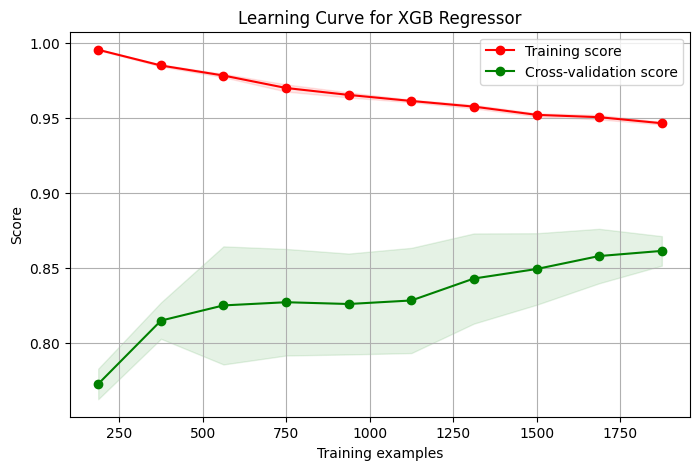

In [111]:
# Learning Curve Plot xgb
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, n_jobs=3, train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)
plt.title("Learning Curve for XGB Regressor")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()

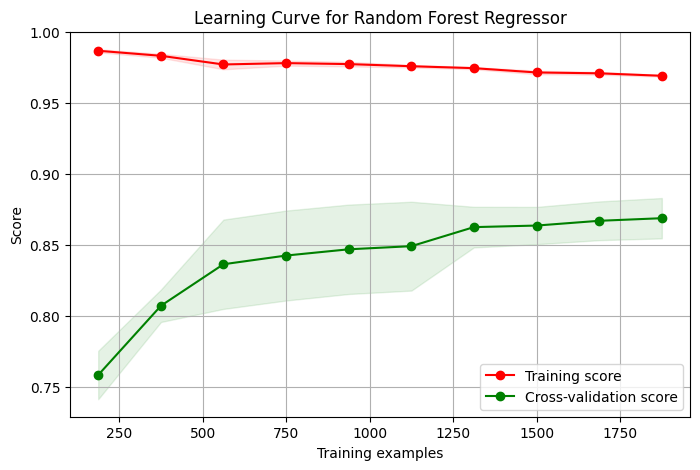

In [112]:
# Learning Curve Plot random Forest
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(best_model1, X_train, y_train, cv=5, n_jobs=3, train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)
plt.title("Learning Curve for Random Forest Regressor")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()

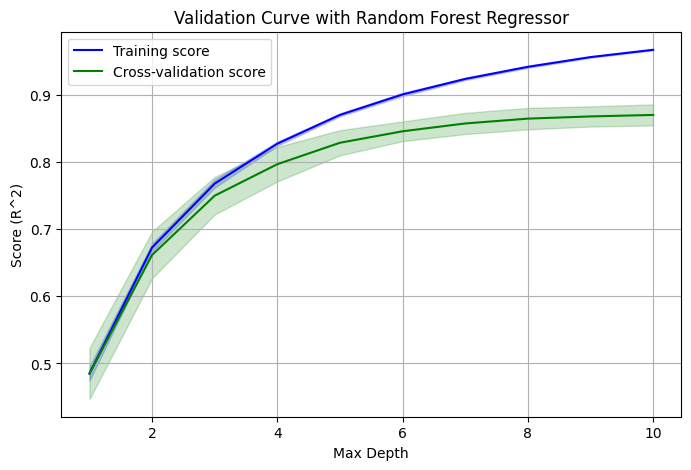

In [113]:
from sklearn.model_selection import validation_curve

# Define the parameter name and range for the validation curve
param_name = 'rf__max_depth'  # XGBoost's parameter for tree depth
param_range = np.arange(1, 11)  # Exploring depths from 1 to 10

# Generate the validation curve
train_scores, test_scores = validation_curve(
    best_model1,  # Ensure you use the best model from your hyperparameter tuning
    X_train, y_train, 
    param_name=param_name, 
    param_range=param_range, 
    cv=10, 
    scoring="r2",  # You can change this to another scoring method depending on what you're interested in
    n_jobs=-1  # Use all available cores
)

# Calculate means and standard deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting the validation curve
plt.figure(figsize=(8, 5))
plt.plot(param_range, train_mean, label='Training score', color='blue')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.plot(param_range, test_mean, label='Cross-validation score', color='green')
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color='green', alpha=0.2)

plt.title("Validation Curve with Random Forest Regressor")
plt.xlabel("Max Depth")
plt.ylabel("Score (R^2)")
plt.legend(loc="best")
plt.grid(True)
plt.show()


In [ ]:
param_name = 'xgb__learning_rate'  # Choose a hyperparameter to vary
param_range = np.logspace(-3, 2, num=5)

train_scores, test_scores = validation_curve(
    pipelines['xgb'], X_train, y_train, param_name=param_name, param_range=param_range, cv=10)

# Calculate means and standard deviations 
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.plot(param_range, train_mean, label='Training score')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(param_range, test_mean, label='Cross-validation score')
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.1)

plt.title("Validation Curve: Varying C")
plt.xlabel("C (Regularization parameter)")
plt.ylabel("Score")
plt.legend()
plt.xscale('log') 
plt.show()
